Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [37]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from google.colab import drive

In [38]:
## The data is used by mounting the google drive, as follows :
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [39]:
os.listdir('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration')

['Train', 'Test']

In [40]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [41]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Training Images count:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Images count:", image_count_test)

Training Images count: 2239
Test Images count: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [42]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [43]:
## Creating the train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                              label_mode='categorical',seed=123, validation_split=0.2,   # Split 80% for training, 20% for validation
                                                              subset='training')


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [44]:
## Creating validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size, image_size=(img_height,img_width),
                                                              label_mode='categorical',seed=123, validation_split=0.2,   # Split 80% for training, 20% for validation
                                                              subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [45]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print("Classes of Skin Cancer:", class_names)

Classes of Skin Cancer: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [46]:
## Create test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


### Visualize the data
#### visualize one instance of all the nine classes present in the dataset

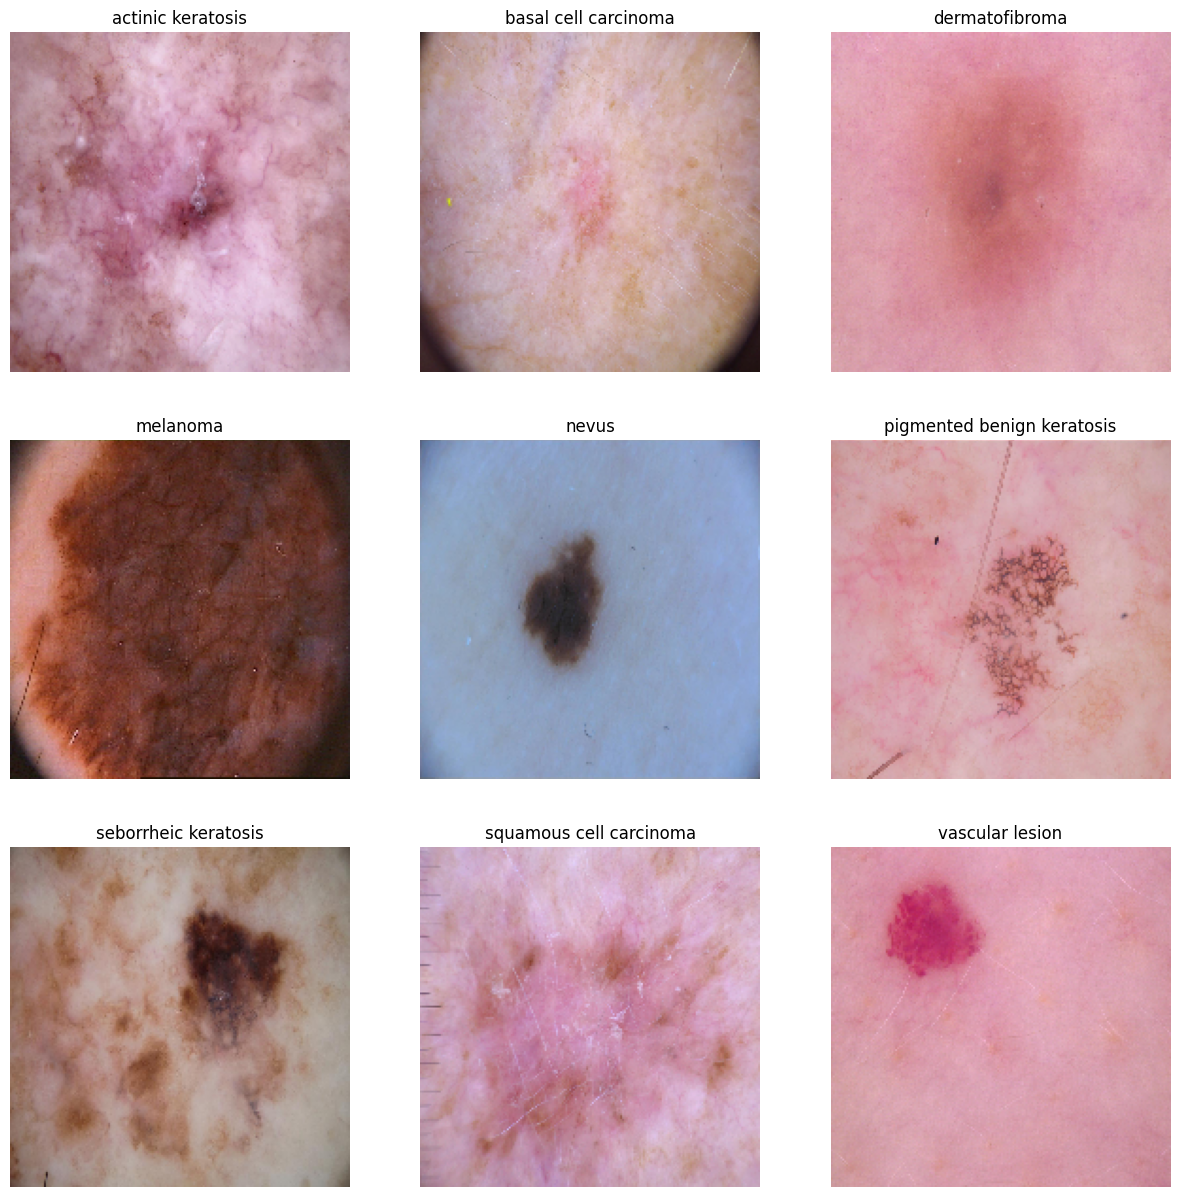

In [47]:
# Dictionary to store the path of images as per the class
files_path_dict = {}

#all the classes of Skin Cancer
class_names = train_ds.class_names

# Populate the dictionary with image paths per class
for class_name in class_names:
    files_path_dict[class_name] = list(map(lambda x: os.path.join(data_dir_train, class_name, x), os.listdir(os.path.join(data_dir_train, class_name))))

# Visualize one image from each class
plt.figure(figsize=(15, 15))

# Loop through each class and display one image
index = 0
for class_name in class_names:
    path_list = files_path_dict[class_name][:1]  # Get the first image path for each class
    index += 1
    plt.subplot(3, 3, index)  # 3x3 grid layout
    img = load_img(path_list[0], target_size=(img_height, img_width))  # Load and resize the image
    plt.imshow(img)  # Display the image
    plt.title(class_name)  # Title with the class name
    plt.axis("off")  # Hide axes for better clarity

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. The labels are one-hot encoded.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

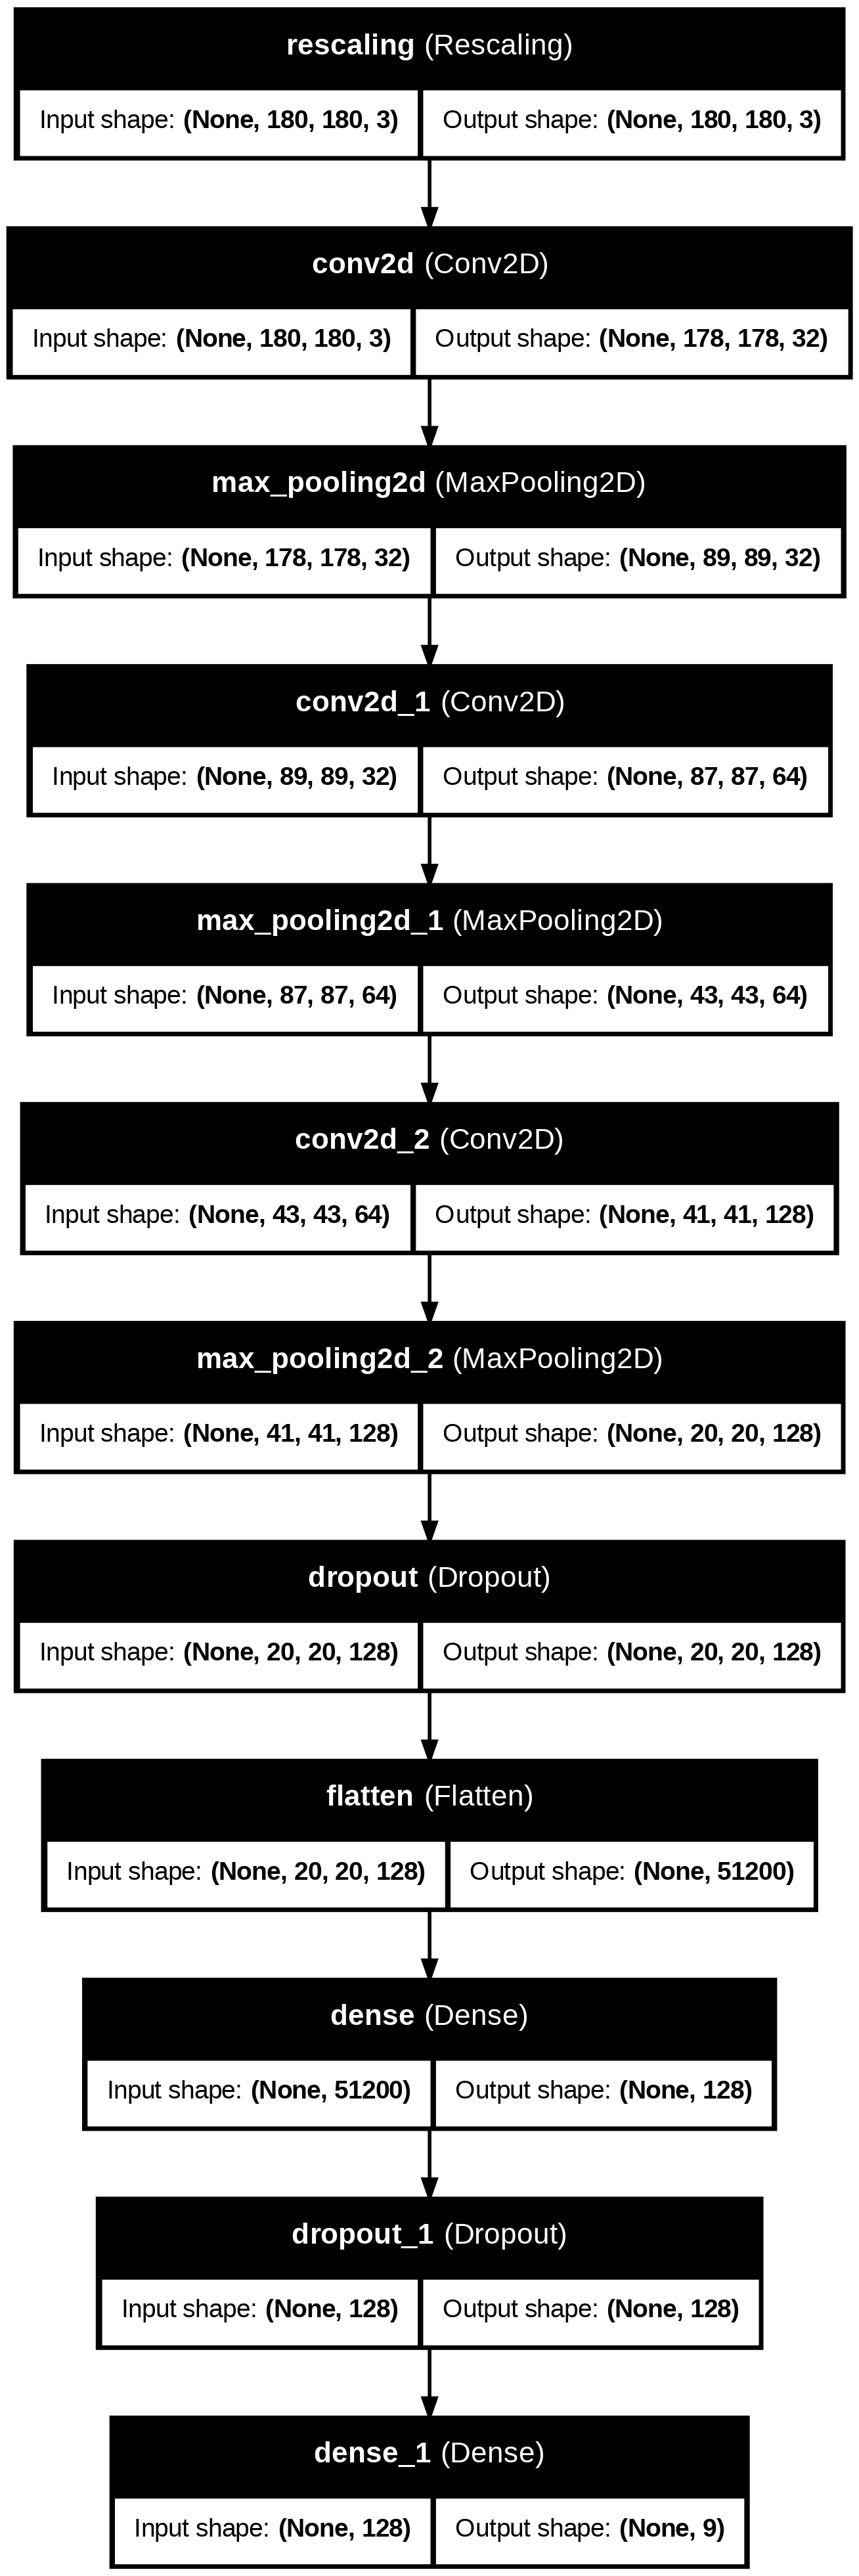

In [ ]:
# vizualizing the model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.


model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=2
)

Epoch 1/20
106/106 - 20s - 186ms/step - accuracy: 0.3252 - loss: 1.8711 - val_accuracy: 0.4368 - val_loss: 1.5683
Epoch 2/20
106/106 - 2s - 21ms/step - accuracy: 0.4764 - loss: 1.4388 - val_accuracy: 0.5148 - val_loss: 1.2844
Epoch 3/20
106/106 - 2s - 21ms/step - accuracy: 0.5286 - loss: 1.2932 - val_accuracy: 0.5643 - val_loss: 1.2250
Epoch 4/20
106/106 - 2s - 21ms/step - accuracy: 0.5613 - loss: 1.2151 - val_accuracy: 0.5915 - val_loss: 1.1729
Epoch 5/20
106/106 - 2s - 21ms/step - accuracy: 0.5946 - loss: 1.1106 - val_accuracy: 0.6104 - val_loss: 1.1344
Epoch 6/20
106/106 - 2s - 21ms/step - accuracy: 0.5964 - loss: 1.1165 - val_accuracy: 0.6187 - val_loss: 1.1306
Epoch 7/20
106/106 - 2s - 21ms/step - accuracy: 0.6347 - loss: 1.0019 - val_accuracy: 0.6564 - val_loss: 1.1355
Epoch 8/20
106/106 - 2s - 22ms/step - accuracy: 0.6713 - loss: 0.9183 - val_accuracy: 0.6777 - val_loss: 1.0645
Epoch 9/20
106/106 - 2s - 21ms/step - accuracy: 0.6913 - loss: 0.8788 - val_accuracy: 0.6458 - val_los

### Visualizing training results

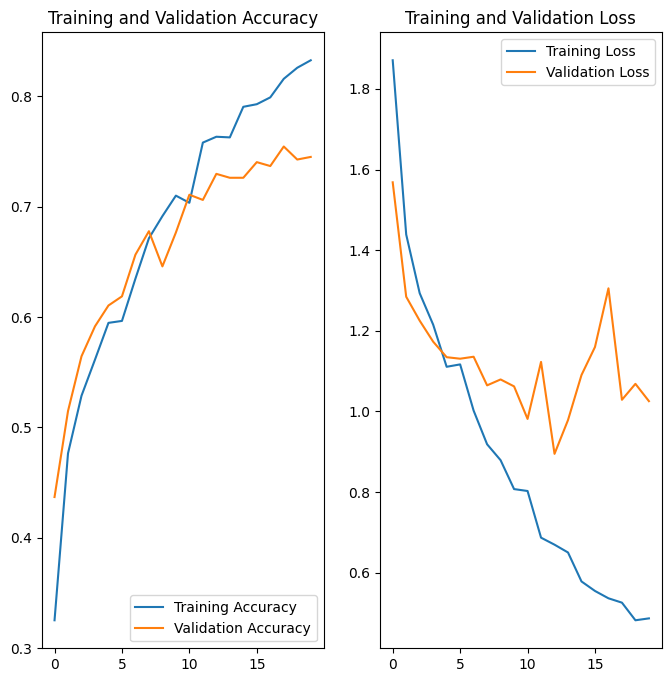

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Key Insights

- Training accuracy steadily improved over time, reaching 83% by epoch 20.
- Validation accuracy fluctuated, peaking at 74.5%.
- Validation Loss decreased during the early epochs, with some fluctuations in later stages.
- The gap between training accuracy and validation accuracy increases slightly, the same holds true for training and validation loss as well.
- This indicates that while the model is improving in terms of training accuracy, there may be some ***overfitting***.
* To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

In [49]:
# data augmentation
augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

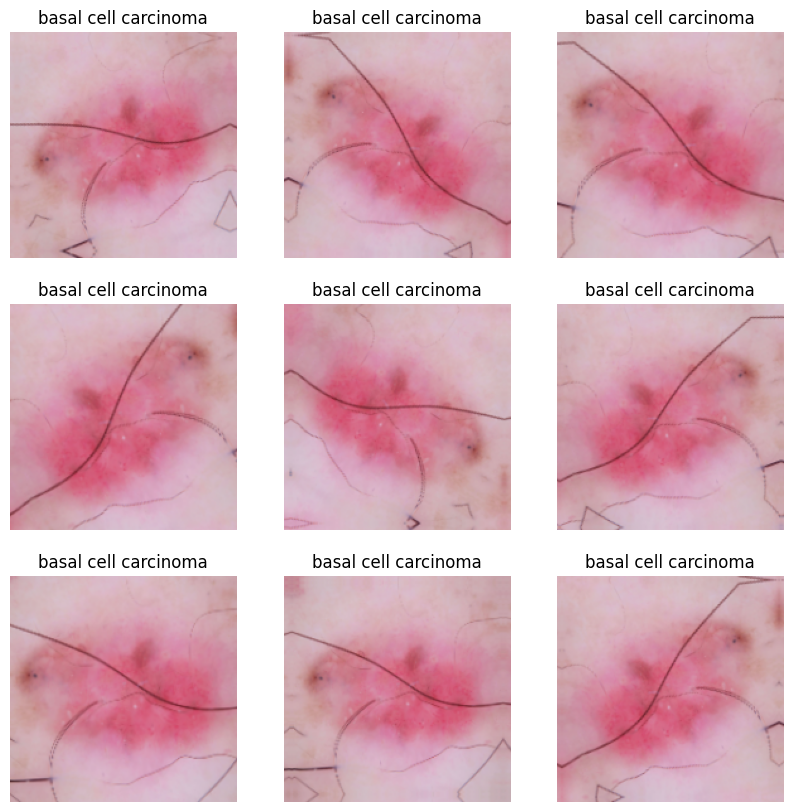

In [50]:
# visualizing how the augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[0].numpy())])
        plt.axis("off")

### Create the model, compile and train the model


In [ ]:
# Creating the model

#Sequential allows you to create models layer-by-layer
model = Sequential()
model.add(augmentation_data)
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [ ]:
# Copile the model
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

### Training the model

In [ ]:
# Define ModelCheckpoint callback
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    'model_best.keras',
    monitor='val_loss',             # Monitor validation loss (or accuracy)
    save_best_only=True,            # Save only the best model
    mode='min',                     # Minimize validation loss
    verbose=1                       # Show output when saving
)



In [ ]:
history = model.fit(
  train_ds,                      # Training data
    epochs=20,                      # Number of training epochs
    validation_data=val_ds,         # Validation data
    callbacks=[checkpoint_callback], # Add callback ModelCheckpoint
    verbose=2                       # Show progress for each epoch

)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.43514, saving model to model_best.keras
106/106 - 8s - 73ms/step - accuracy: 0.3505 - loss: 1.7886 - val_accuracy: 0.4970 - val_loss: 1.4351
Epoch 2/20

Epoch 2: val_loss improved from 1.43514 to 1.37702, saving model to model_best.keras
106/106 - 3s - 30ms/step - accuracy: 0.4900 - loss: 1.4513 - val_accuracy: 0.5266 - val_loss: 1.3770
Epoch 3/20

Epoch 3: val_loss did not improve from 1.37702
106/106 - 3s - 26ms/step - accuracy: 0.5351 - loss: 1.3140 - val_accuracy: 0.5100 - val_loss: 1.4519
Epoch 4/20

Epoch 4: val_loss improved from 1.37702 to 1.23148, saving model to model_best.keras
106/106 - 3s - 30ms/step - accuracy: 0.5248 - loss: 1.3022 - val_accuracy: 0.5655 - val_loss: 1.2315
Epoch 5/20

Epoch 5: val_loss did not improve from 1.23148
106/106 - 3s - 26ms/step - accuracy: 0.5607 - loss: 1.2309 - val_accuracy: 0.5514 - val_loss: 1.2721
Epoch 6/20

Epoch 6: val_loss improved from 1.23148 to 1.20826, saving model to model_best

### Visualizing the results

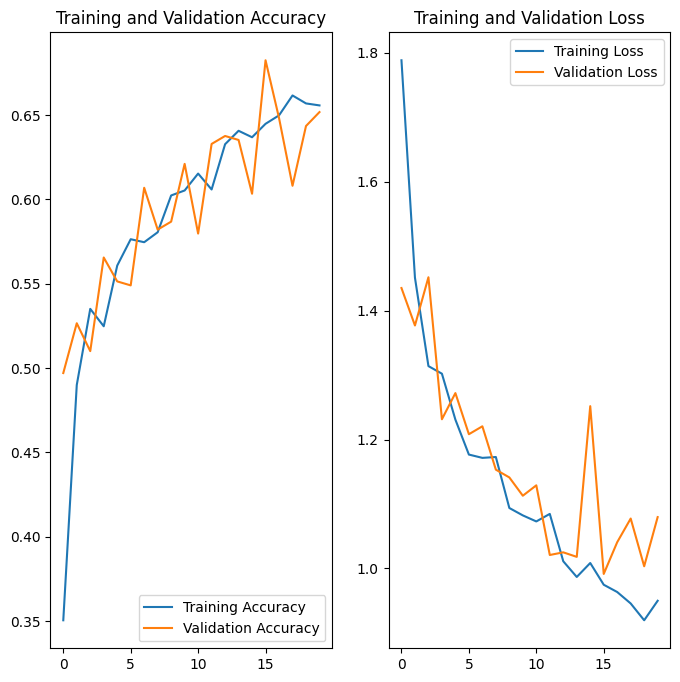

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Key Insights:**

- Training Accuracy: The training accuracy improves gradually over time.
- Training Loss: The training loss decreases steadily, showing that the model is learning and fitting the training data better over time.
- Validation Accuracy: VWhile the validation accuracy shows steady improvement, there are fluctuations in specific epochs (notably in Epochs 7, 11, 13, and 19), suggesting some instability in model generalization.
- Validation Loss: Validation loss decreases notably initially till epoch 16, but shows no further improvement after that.
- The model starts to show signs of overfitting. While the training accuracy continues to rise, the validation performance (both accuracy and loss) becomes more stable or worsens slightly, signaling that the model is starting to memorize the training data rather than generalize well.


The fact that the validation loss plateaus could imply that further training might not yield significant improvements.

**Suggestions for Improvement:**
* Early Stopping: Use EarlyStopping to stop training when validation loss stalls.

* Data Augmentation: Enhance augmentation or data diversity for better generalization.

* Fix Class Imbalance

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [15]:
def class_distribution_count(directory):
    count = []

    # Iterate over each subdirectory (class folder)
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():  # Check if it's a directory (class)
            # Count the number of files in each subdirectory (class)
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    # Get the names of the subdirectories (class names)
    sub_directory = [name for name in os.listdir(directory)
                     if os.path.isdir(os.path.join(directory, name))]

    # Calculate the total number of images
    total_images = sum(count)

    # Calculate the percentage for each class
    percentage = [round((x / total_images) * 100, 2) for x in count]

    # Create a DataFrame with class names, image counts, and percentage distribution
    df = pd.DataFrame(list(zip(sub_directory, count, percentage)), columns=['Class', 'No. of Images', 'Percentage'])

    # Return the DataFrame
    return df

df = class_distribution_count(data_dir_train)
print(df)

                        Class  No. of Images  Percentage
0        seborrheic keratosis             77        3.44
1        basal cell carcinoma            376       16.79
2  pigmented benign keratosis            462       20.63
3           actinic keratosis            114        5.09
4             vascular lesion            139        6.21
5              dermatofibroma             95        4.24
6                       nevus            357       15.94
7     squamous cell carcinoma            181        8.08
8                    melanoma            438       19.56


<Axes: xlabel='No. of Images', ylabel='Class'>

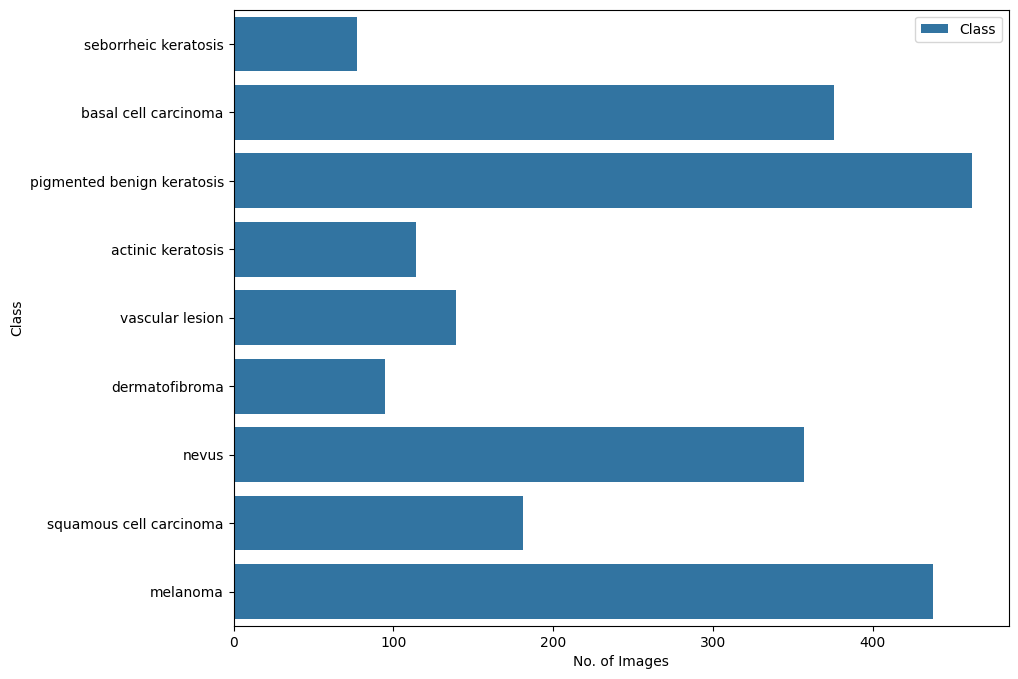

In [16]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Images", y="Class", data=df,
            label="Class")

#### **Findings:**
- `seborrheic keratosis` has the least number of samples, which make up about 3.5 percentage of the train data
- `pigmented benign keratosis` dominates the data in terms proportionate number of samples, with about 20.63 percentage
- It is clear that class imbalance is present


#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C933F0D27D0>: 100%|██████████| 500/500 [00:04<00:00, 101.74 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C933C72CDD0>: 100%|██████████| 500/500 [00:05<00:00, 98.15 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C933F060F90>: 100%|██████████| 500/500 [00:04<00:00, 113.14 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C940414AB10>: 100%|██████████| 500/500 [00:15<00:00, 32.09 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7C933F049C10>: 100%|██████████| 500/500 [00:14<00:00, 35.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C938A068750>: 100%|██████████| 500/500 [00:04<00:00, 106.55 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C933F038B10>: 100%|██████████| 500/500 [00:06<00:00, 75.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C933F0541D0>: 100%|██████████| 500/500 [00:04<00:00, 106.30 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C933C6F6090>: 100%|██████████| 500/500 [00:04<00:00, 103.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [51]:
data_dir_augmented = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration_augmented/Train")


In [52]:
image_count_train = len(list(data_dir_augmented.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [53]:
# extracting the augmented image paths in a list
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_augmented, '*','output', '*.jpg'))]
path_list[:5]

['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration_augmented/Train/melanoma/output/melanoma_original_ISIC_0010241.jpg_0bf12f6a-6be4-4ffe-aa1b-496195c4c9e6.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration_augmented/Train/melanoma/output/melanoma_original_ISIC_0010655.jpg_1ecad8f2-5409-4274-a841-65f6da3003a4.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration_augmented/Train/melanoma/output/melanoma_original_ISIC_0010398.jpg_4a1ffd31-e4a1-41a5-b90e-bbaf3d2a5fc3.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration_augmented/Train/melanoma/output/melanoma_original_ISIC_0000169.jpg_19b547cf-4c09-41b0-9fa2-3fd32ee5643f.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration_augmented/Train/melanoma/output/melanoma

In [54]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_augmented, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [55]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [56]:
## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

[('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010917.jpg', 'seborrheic keratosis'), ('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010923.jpg', 'seborrheic keratosis'), ('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010898.jpg', 'seborrheic keratosis'), ('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010872.jpg', 'seborrheic keratosis'), ('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/ISIC_0010860.jpg', 'seborrheic keratosis')]


,Image Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Skin c...,seborrheic keratosis


In [57]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [58]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

#### Create a training dataset

In [59]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_augmented,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [60]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_augmented,
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [61]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Model Creation

In [62]:
#Sequential allows you to create models layer-by-layer
model = Sequential()
model.add(augmentation_data)
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer (normalization)

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile your model

In [63]:
# compile the model
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### Train the model

In [64]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop],
  verbose=2
)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.40535, saving model to model.keras
169/169 - 18s - 105ms/step - accuracy: 0.2938 - loss: 1.8317 - val_accuracy: 0.4053 - val_loss: 1.5952
Epoch 2/50

Epoch 2: val_accuracy improved from 0.40535 to 0.47290, saving model to model.keras
169/169 - 5s - 28ms/step - accuracy: 0.4011 - loss: 1.5602 - val_accuracy: 0.4729 - val_loss: 1.3788
Epoch 3/50

Epoch 3: val_accuracy improved from 0.47290 to 0.51967, saving model to model.keras
169/169 - 5s - 29ms/step - accuracy: 0.4408 - loss: 1.4642 - val_accuracy: 0.5197 - val_loss: 1.2931
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.51967
169/169 - 4s - 26ms/step - accuracy: 0.4664 - loss: 1.3942 - val_accuracy: 0.5145 - val_loss: 1.2796
Epoch 5/50

Epoch 5: val_accuracy did not improve from 0.51967
169/169 - 4s - 26ms/step - accuracy: 0.4935 - loss: 1.3390 - val_accuracy: 0.5174 - val_loss: 1.2914
Epoch 6/50

Epoch 6: val_accuracy improved from 0.51967 to 0.53378, saving model t

#### Visualize the model results

In [65]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,944,413 (76.08 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,296,276 (50.72 MB)

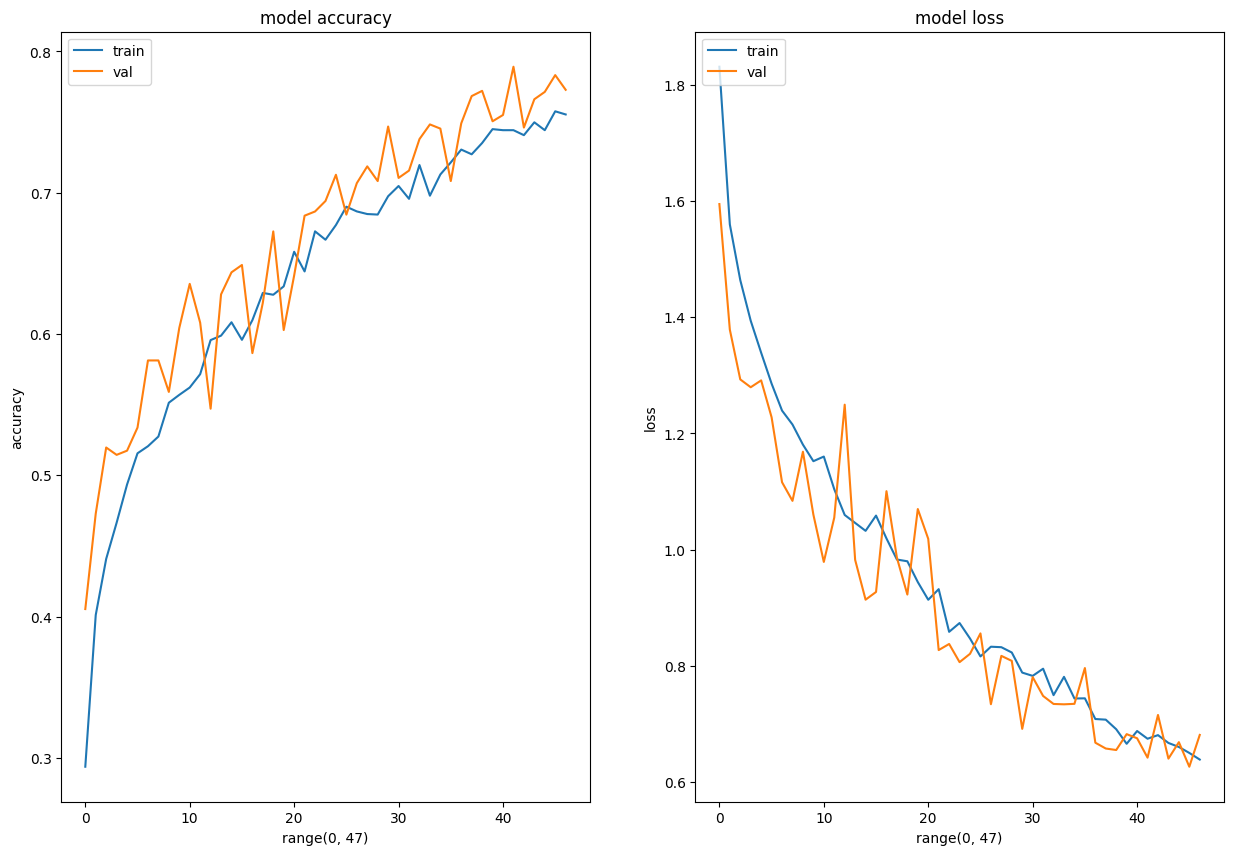

In [66]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Key Insights
- The model gradually improved in performance throughout the training, with the validation accuracy (val_accuracy) steadily increasing up to epoch 42 and peaking at 0.78916 (epoch 42). After epoch 42, the validation accuracy plateaued, with minor fluctuations (a slight decrease in later epochs).
- Since the validation accuracy plateaues and has slight variation towards the end while training accuracy improves there may be slight overfitting




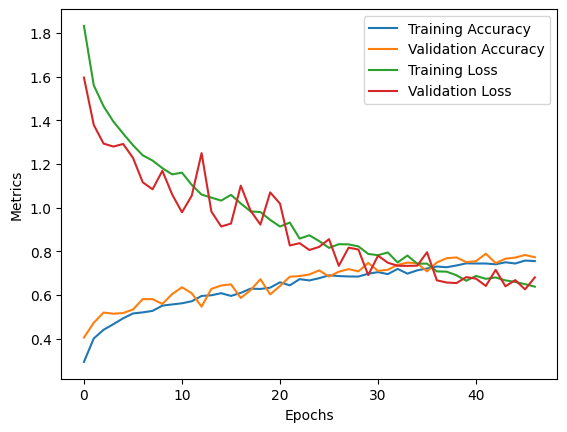

In [67]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [68]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4856 - loss: 3.8890
Test Loss: 4.3445539474487305
Test Accuracy: 0.4406779706478119


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


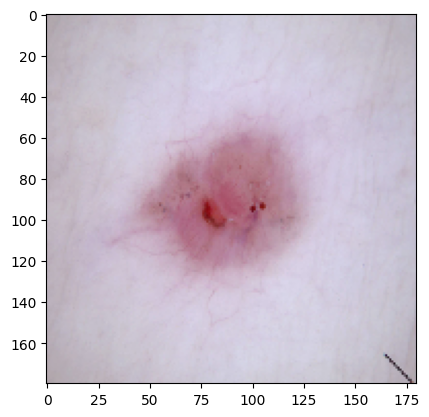

In [69]:
image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)
